In [47]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [48]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [49]:
import numpy as np
import pandas as pd
import opendatasets as od
from typing import Any, List, Dict, Tuple
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
import warnings


warnings.filterwarnings("ignore")

# Dateset description

Cardiovascular diseases (CVDs) are the leading cause of death globally, claiming 17.9 million lives annually (31% of all deaths). Four out of five CVD deaths are due to heart attacks and strokes, with one-third occurring in people under 70. Early detection and management of CVDs, especially for those with risk factors like hypertension, diabetes, or hyperlipidaemia, can significantly reduce mortality. Machine learning models can aid in early diagnosis and prediction of heart diseases.

---

**Attributes**  

- Age: Patient's age (years).
- Sex: [M: Male, F: Female].
- ChestPainType: Chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic].
- RestingBP: Resting blood pressure (mm Hg).
- Cholesterol: Serum cholesterol (mg/dL).
- FastingBS: Fasting blood sugar [1: >120 mg/dL, 0: otherwise].
- RestingECG: ECG results [Normal, ST, LVH].
- MaxHR: Max heart rate achieved (60–202).
- ExerciseAngina: Exercise-induced angina [Y: Yes, N: No].
- Oldpeak: ST depression (numeric).
- ST_Slope: Slope of peak ST segment [Up, Flat, Down].
- HeartDisease: Diagnosis [1: Heart disease, 0: Normal].

---

**Source**

This dataset combines 5 heart datasets with 11 common features, making it the largest heart disease dataset available. The datasets are:
1. Cleveland: 303 observations.
2. Hungarian: 294 observations.
3. Switzerland: 123 observations.
4. Long Beach VA: 200 observations.
5. Stalog: 270 observations.

In [50]:
link = "https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction"
od.download(link)

df = pd.read_csv("heart-failure-prediction/heart.csv")
df.head(5)

Skipping, found downloaded files in ".\heart-failure-prediction" (use force=True to force download)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# EDA

## Dataset info

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [52]:
# numerical features
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [53]:
# categorical features
for column in df.select_dtypes(include=["object", "category"]).columns:
    print(f"Unique values in column '{column}':")
    print(df[column].unique())
    print()

Unique values in column 'Sex':
['M' 'F']

Unique values in column 'ChestPainType':
['ATA' 'NAP' 'ASY' 'TA']

Unique values in column 'RestingECG':
['Normal' 'ST' 'LVH']

Unique values in column 'ExerciseAngina':
['N' 'Y']

Unique values in column 'ST_Slope':
['Up' 'Flat' 'Down']



## Dataset Insights

The dataset contains 918 records and includes 12 columns.

### 1. Key Statistics for Quantitative Variables
Let's consider the key statistics for some of the quantitative variables:

- **Age**: The average age is 53.5 years, with a range from 28 to 77 years. This indicates that the dataset primarily represents the adult population.

- **RestingBP (Resting Blood Pressure)**: The average resting blood pressure is 132 mmHg, with a minimum value of 0 (which might be an error or anomaly) and a maximum value of 200 mmHg.

- **Cholesterol**: The average cholesterol level is 198.8 mg/dL. The minimum value is 0 and the maximum value is 603, which could suggest the presence of anomalous data or rare cases.

- **FastingBS (Fasting Blood Sugar)**: Almost all values are 0 (indicating no diabetes), with a few exceptions where the fasting blood sugar level is greater than 0.

- **MaxHR (Maximum Heart Rate)**: The average maximum heart rate during exercise is 136.8 bpm, with a range from 60 to 202 bpm, which is within normal limits for adults.

- **Oldpeak (ST Depression on ECG)**: The average value is 0.89, indicating moderate ST segment depression for most observations. The values range from -2.6 (normal) to 6.2 (significant deviation).

### 2. Categorical Variables
- **Sex**: The "Sex" column contains two unique values — 'M' (male) and 'F' (female), indicating that the dataset includes both male and female populations.

- **ChestPainType**: The "ChestPainType" column has four unique categories:
  - 'ATA' — typical angina,
  - 'NAP' — atypical angina,
  - 'ASY' — asymptomatic disease,
  - 'TA' — non-anginal chest pain.

- **RestingECG**: The "RestingECG" column contains three unique values:
  - 'Normal' — normal ECG,
  - 'ST' — ST segment changes (e.g., during ischemia),
  - 'LVH' — signs of left ventricular hypertrophy.

- **ExerciseAngina**: The "ExerciseAngina" column has two values:
  - 'N' — no angina with physical exertion,
  - 'Y' — angina with physical exertion.
  
  This could be an important indicator in assessing the risk of heart disease.

- **ST_Slope**: The "ST_Slope" column contains three unique values:
  - 'Up' — ST segment elevation (could indicate acute myocardial infarction),
  - 'Flat' — flat ST segment,
  - 'Down' — ST segment depression (could be associated with ischemia).
  
  This column could be critical in diagnosing heart diseases.

### 3. "HeartDisease" Variable
- **Heart Disease**: This is the target variable. The average value is 0.553, indicating that approximately 55.3% of the patients in the dataset have heart disease.

### 4. Necessary Improvements
- Check for anomalies and outliers in the **RestingBP** and **Cholesterol** columns to ensure data accuracy.
- Analyze the distribution of categorical variables to evaluate their impact on diagnosis.

## Handling of exceptional data in **RestingBP** and **Cholesterol**

In [54]:
restingbp_zeros = (df["RestingBP"] == 0).sum()
cholesterol_zeros = (df["Cholesterol"] == 0).sum()

total_restingbp = df["RestingBP"].count()
total_cholesterol = df["Cholesterol"].count()

restingbp_zeros_percentage = (restingbp_zeros / total_restingbp) * 100
cholesterol_zeros_percentage = (cholesterol_zeros / total_cholesterol) * 100

print(
    f"Number of zero values in RestingBP: {restingbp_zeros} ({restingbp_zeros_percentage:.2f}%)"
)
print(
    f"Number of zero values in Cholesterol: {cholesterol_zeros} ({cholesterol_zeros_percentage:.2f}%)"
)

columns_to_replace = ["Cholesterol", "RestingBP"]
df[columns_to_replace] = df[columns_to_replace].replace(0, np.nan)
mice_imputer = IterativeImputer()
df[columns_to_replace] = mice_imputer.fit_transform(df[columns_to_replace])

Number of zero values in RestingBP: 1 (0.11%)
Number of zero values in Cholesterol: 172 (18.74%)


In [55]:
print(f"Minimum value of Cholesterol: {df['Cholesterol'].min()}")
print(f"Maximum value of Cholesterol: {df['Cholesterol'].max()}")

Minimum value of Cholesterol: 85.0
Maximum value of Cholesterol: 603.0


### Handling Missing Values

- Null values in the **RestingBP** and **Cholesterol** columns were replaced with **NaN**, as null values in these features are errors and unrealistic for real data (for example, blood pressure cannot be zero).
- To fill in the missing values, the **MICE imputation method** was used, which predicts the missing values based on information from other features.
- This approach allows us to retain all rows of data and minimize information loss, which is important for the accuracy of analysis and model building.

## Analysis of feature distributions

In [56]:
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.difference(
    ["HeartDisease"]
)
categorical_features = df.select_dtypes(include=["object"])

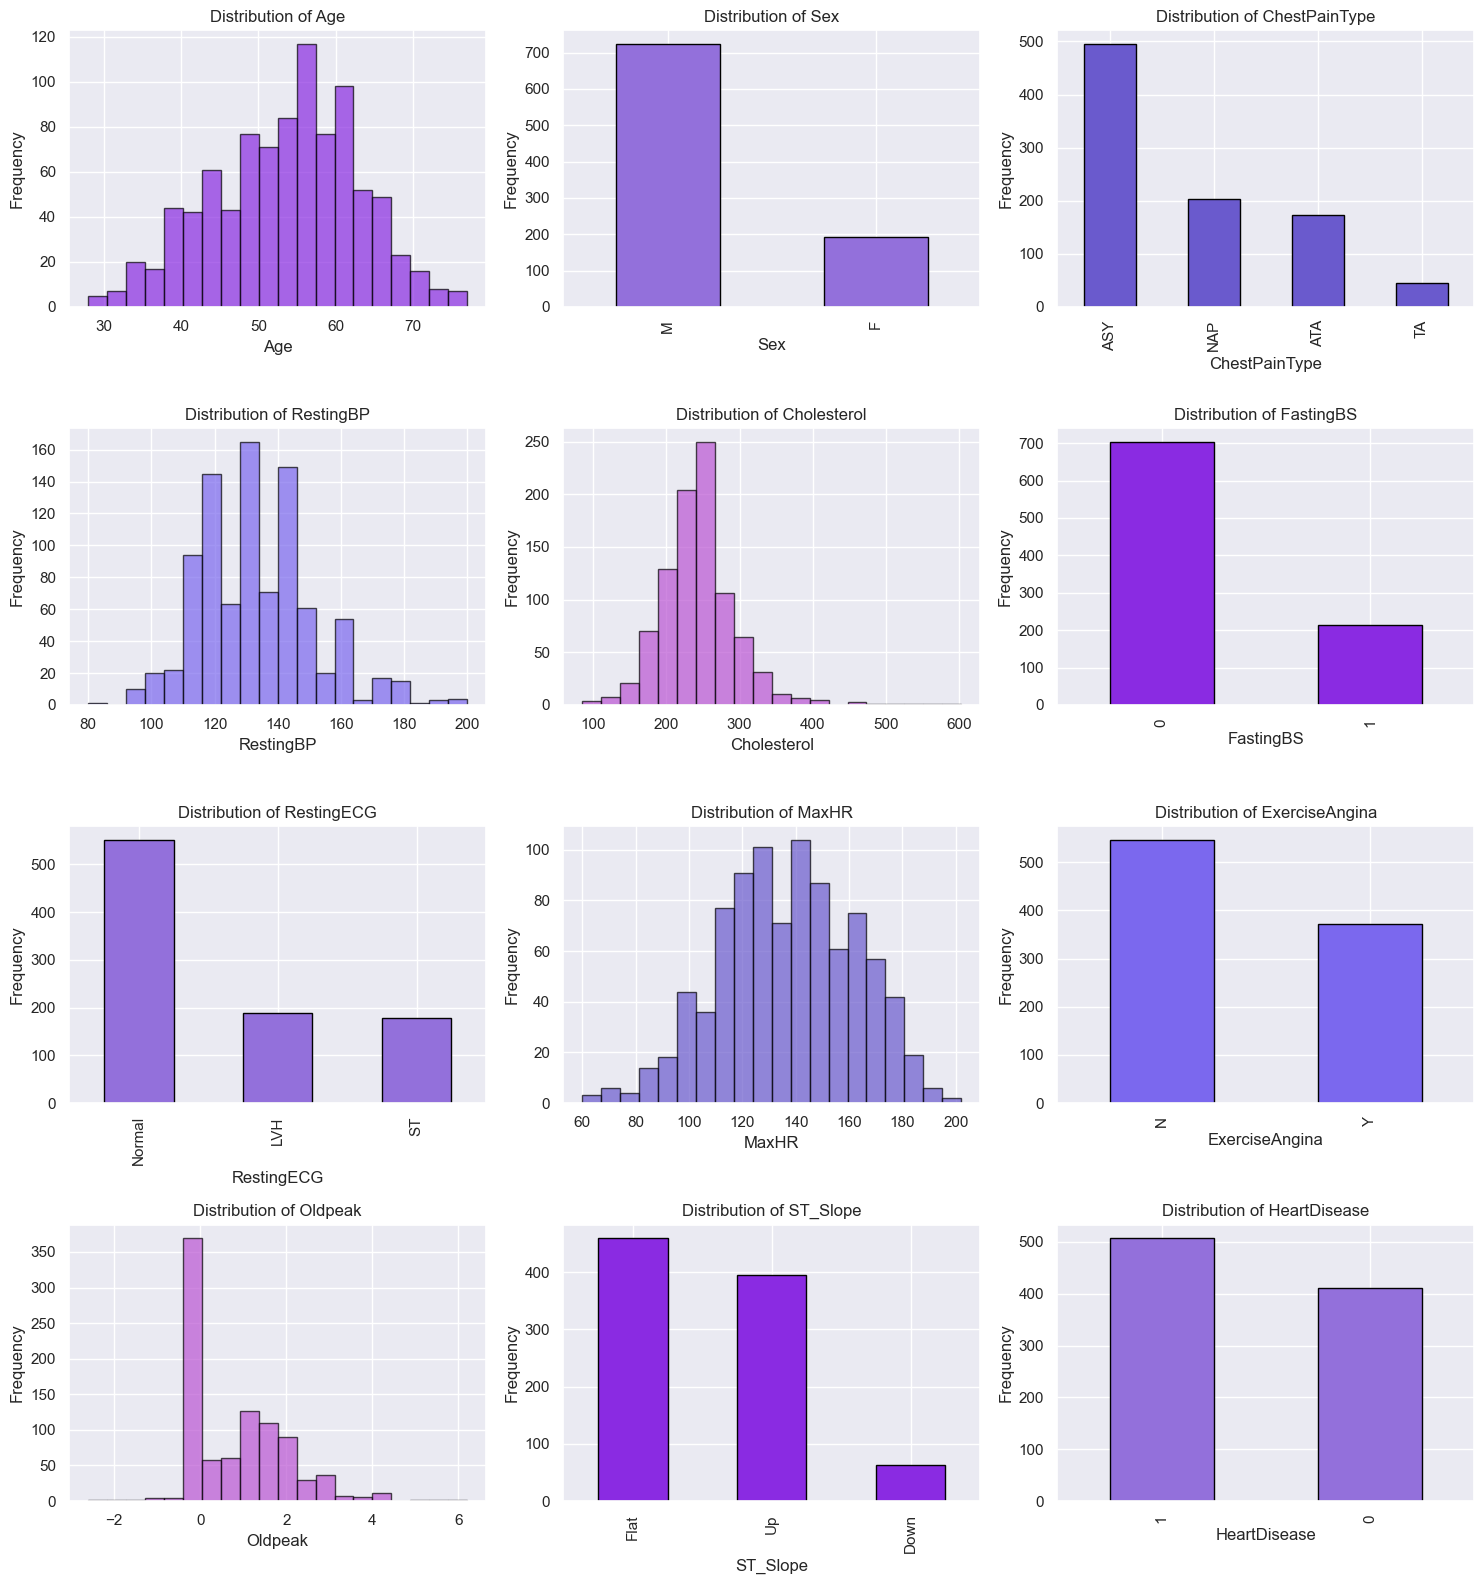

In [57]:
sns.set_theme(style="darkgrid")

# Define grid layout
cols, rows = 3, math.ceil(len(df.columns) / 3)
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

purple_shades = ["#8A2BE2", "#9370DB", "#6A5ACD", "#7B68EE", "#BA55D3"]

# Plot distributions
for i, col in enumerate(df.columns):
    ax = axes[i]
    if df[col].dtype == "object" or df[col].nunique() < 20:
        # Bar plot for categorical data
        df[col].value_counts().plot(
            kind="bar",
            ax=ax,
            color=purple_shades[i % len(purple_shades)],
            edgecolor="black",
            title=f"Distribution of {col}",
        )
    else:
        # Histogram for continuous data
        df[col].plot(
            kind="hist",
            bins=20,
            ax=ax,
            color=purple_shades[i % len(purple_shades)],
            edgecolor="black",
            alpha=0.7,
            title=f"Distribution of {col}",
        )
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Remove extra subplots
for ax in axes[len(df.columns) :]:
    fig.delaxes(ax)

plt.tight_layout()
plt.savefig("image/feature_distributions.png")
plt.show()

In [58]:
for col in df.select_dtypes(include=["object"]).columns:
    value_counts = df[col].value_counts()
    print(f"\n{col} distributions:")
    print(value_counts)
    print("-" * 50)


Sex distributions:
Sex
M    725
F    193
Name: count, dtype: int64
--------------------------------------------------

ChestPainType distributions:
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64
--------------------------------------------------

RestingECG distributions:
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64
--------------------------------------------------

ExerciseAngina distributions:
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64
--------------------------------------------------

ST_Slope distributions:
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64
--------------------------------------------------


- **Sex**: The dataset is predominantly male (725 males, 193 females).
- **ChestPainType**: The most common chest pain type is asymptomatic (ASY, 496), followed by atypical angina (NAP, 203).
- **RestingECG**: Most patients have a normal ECG (552), while 188 have left ventricular hypertrophy (LVH), and 178 show ST changes (ST).
- **ExerciseAngina**: More patients have no exercise-induced angina (N, 547) compared to those who experience it (Y, 371).
- **ST_Slope**: The majority of patients have a flat ST segment (460), followed by an upward slope (395), and fewer have a downward slope (63).

## Correlation analysis

In [59]:
X, y = df[numerical_features], df["HeartDisease"]

In [60]:
X.corr()

,Age,Cholesterol,FastingBS,MaxHR,Oldpeak,RestingBP
Age,1.000000,0.058870,0.198039,-0.382045,0.258612,0.263081
Cholesterol,0.058870,1.000000,0.038036,-0.018650,0.054704,0.106671
FastingBS,0.198039,0.038036,1.000000,-0.131438,0.052698,0.067811
MaxHR,-0.382045,-0.018650,-0.131438,1.000000,-0.160691,-0.109662
Oldpeak,0.258612,0.054704,0.052698,-0.160691,1.000000,0.174220
RestingBP,0.263081,0.106671,0.067811,-0.109662,0.174220,1.000000


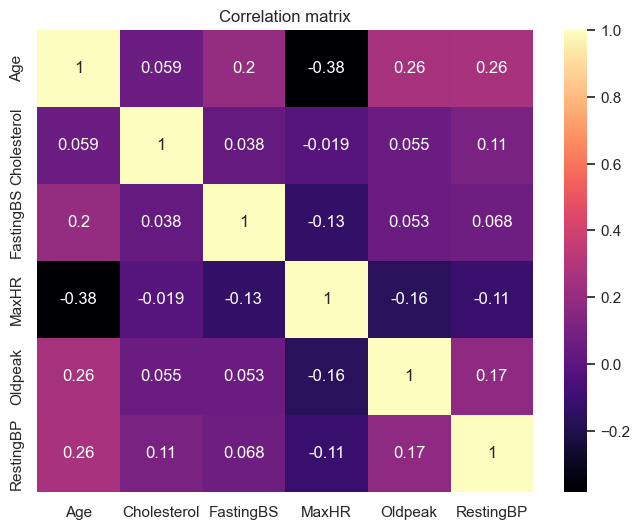

In [61]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(8, 6))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap="magma")
plt.title("Correlation matrix")
plt.savefig("image/correlation_matrix.png")
plt.show()

### Correlation Insights:

- **Age and MaxHR**: Strong negative correlation (**-0.38**). As age increases, the maximum heart rate tends to decrease, which is expected due to age-related changes in cardiovascular function.
- **Age and Oldpeak**: Moderate positive correlation (**0.26**). Older individuals may show slightly higher ST depression (Oldpeak), potentially due to age-related cardiovascular issues.
- **RestingBP and Age**: Moderate positive correlation (**0.26**). Older individuals tend to have higher resting blood pressure, which is consistent with age-related hypertension trends.
- **MaxHR and Oldpeak**: Moderate negative correlation (**-0.16**). Lower maximum heart rate is somewhat associated with higher ST depression, which may indicate greater cardiovascular stress or heart disease.
- **MaxHR and RestingBP**: Very weak negative correlation (**-0.11**). There is minimal relationship between maximum heart rate and resting blood pressure.
- **Cholesterol and RestingBP**: Very weak positive correlation (**0.11**). Cholesterol levels show a very slight positive correlation with resting blood pressure, but the relationship is not strong. 

No strong positive or negative correlations are observed between **Cholesterol** and other variables, indicating that cholesterol may not be a strong predictor for other cardiovascular metrics in this dataset.

In [62]:
X.corrwith(y)

Age            0.282039
Cholesterol    0.092268
FastingBS      0.267291
MaxHR         -0.400421
Oldpeak        0.403951
RestingBP      0.117938
dtype: float64

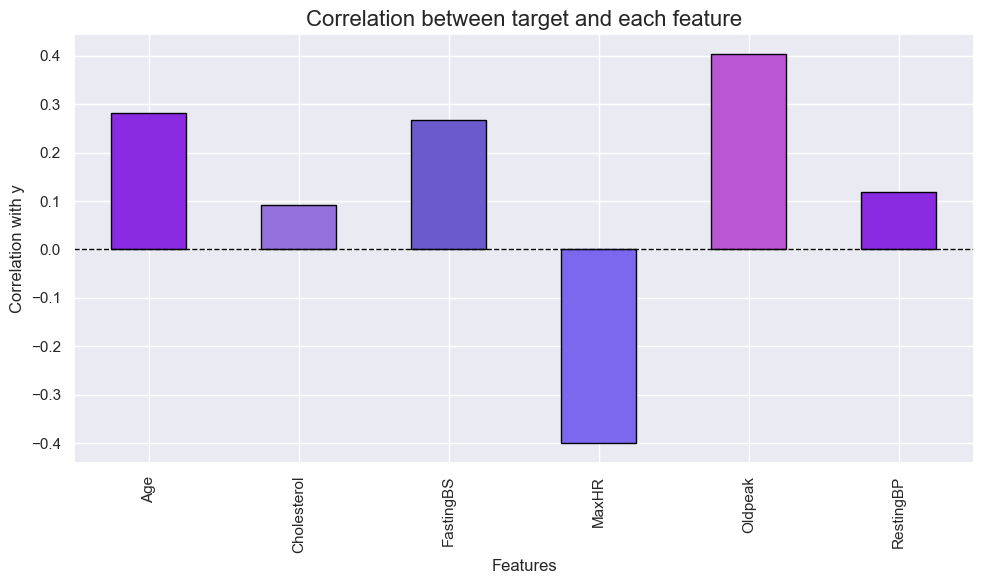

In [63]:
purple_shades = ["#8A2BE2", "#9370DB", "#6A5ACD", "#7B68EE", "#BA55D3"]

correlations = X.corrwith(y)

plt.figure(figsize=(10, 6))
ax = correlations.plot(
    kind="bar", color=purple_shades[: len(correlations)], edgecolor="black"
)
plt.title("Correlation between target and each feature", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Correlation with y", fontsize=12)

ax.axhline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.savefig("image/correlation_target.png")
plt.show()

### Correlation Insights with Target Variable (HeartDisease):

- **MaxHR**: Strong negative correlation (**-0.40**). Higher maximum heart rate is associated with a lower likelihood of heart disease, indicating that individuals with lower heart rates may be at higher risk.
- **Oldpeak**: Strong positive correlation (**0.40**). Greater ST depression on the ECG (Oldpeak) is associated with a higher likelihood of heart disease, which is a known indicator of cardiovascular issues.
- **Age**: Moderate positive correlation (**0.28**). Older age is moderately associated with a higher likelihood of heart disease.
- **FastingBS**: Moderate positive correlation (**0.27**). Higher fasting blood sugar levels are moderately associated with an increased likelihood of heart disease.
- **RestingBP**: Weak positive correlation (**0.12**). Resting blood pressure has a slight positive association with heart disease, but the correlation is not strong.
- **Cholesterol**: Very weak positive correlation (**0.09**). Cholesterol shows a very weak relationship with heart disease in this dataset, suggesting it may not be a strong predictor in this case.

## Target variable analysis

In [64]:
X, y = df[numerical_features], df["HeartDisease"]

              Count  Proportion
HeartDisease                   
1               508      0.5534
0               410      0.4466


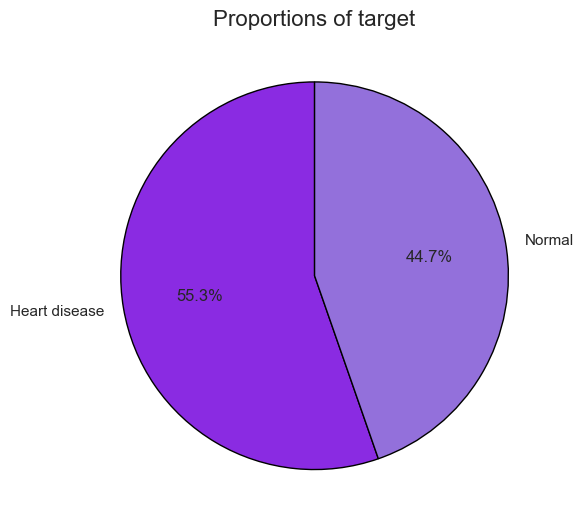

In [65]:
result = pd.DataFrame(
    {
        "Count": y.value_counts(),
        "Proportion": (y.value_counts() / len(y)).round(4),
    }
)

print(result)

sns.set_theme(style="darkgrid")
purple_shades = ["#8A2BE2", "#9370DB", "#6A5ACD", "#7B68EE", "#BA55D3"]

labels = {0: "Normal", 1: "Heart disease"}

ax = result["Count"].plot(
    kind="pie",
    autopct="%.1f%%",  # Show percentages on the pie chart
    colors=purple_shades[: len(result["Count"].unique())],
    startangle=90,
    wedgeprops={"edgecolor": "black", "linewidth": 1},
    figsize=(6, 6),
    labels=[labels[i] for i in result.index],
)

ax.set_title("Proportions of target", fontsize=16)
ax.set_ylabel("")

plt.tight_layout()
plt.savefig("image/target_distribution.png")
plt.show()

**TODO** Добавить распределение целевой по остальным значениям.

## Density plots for features and target variable distribution

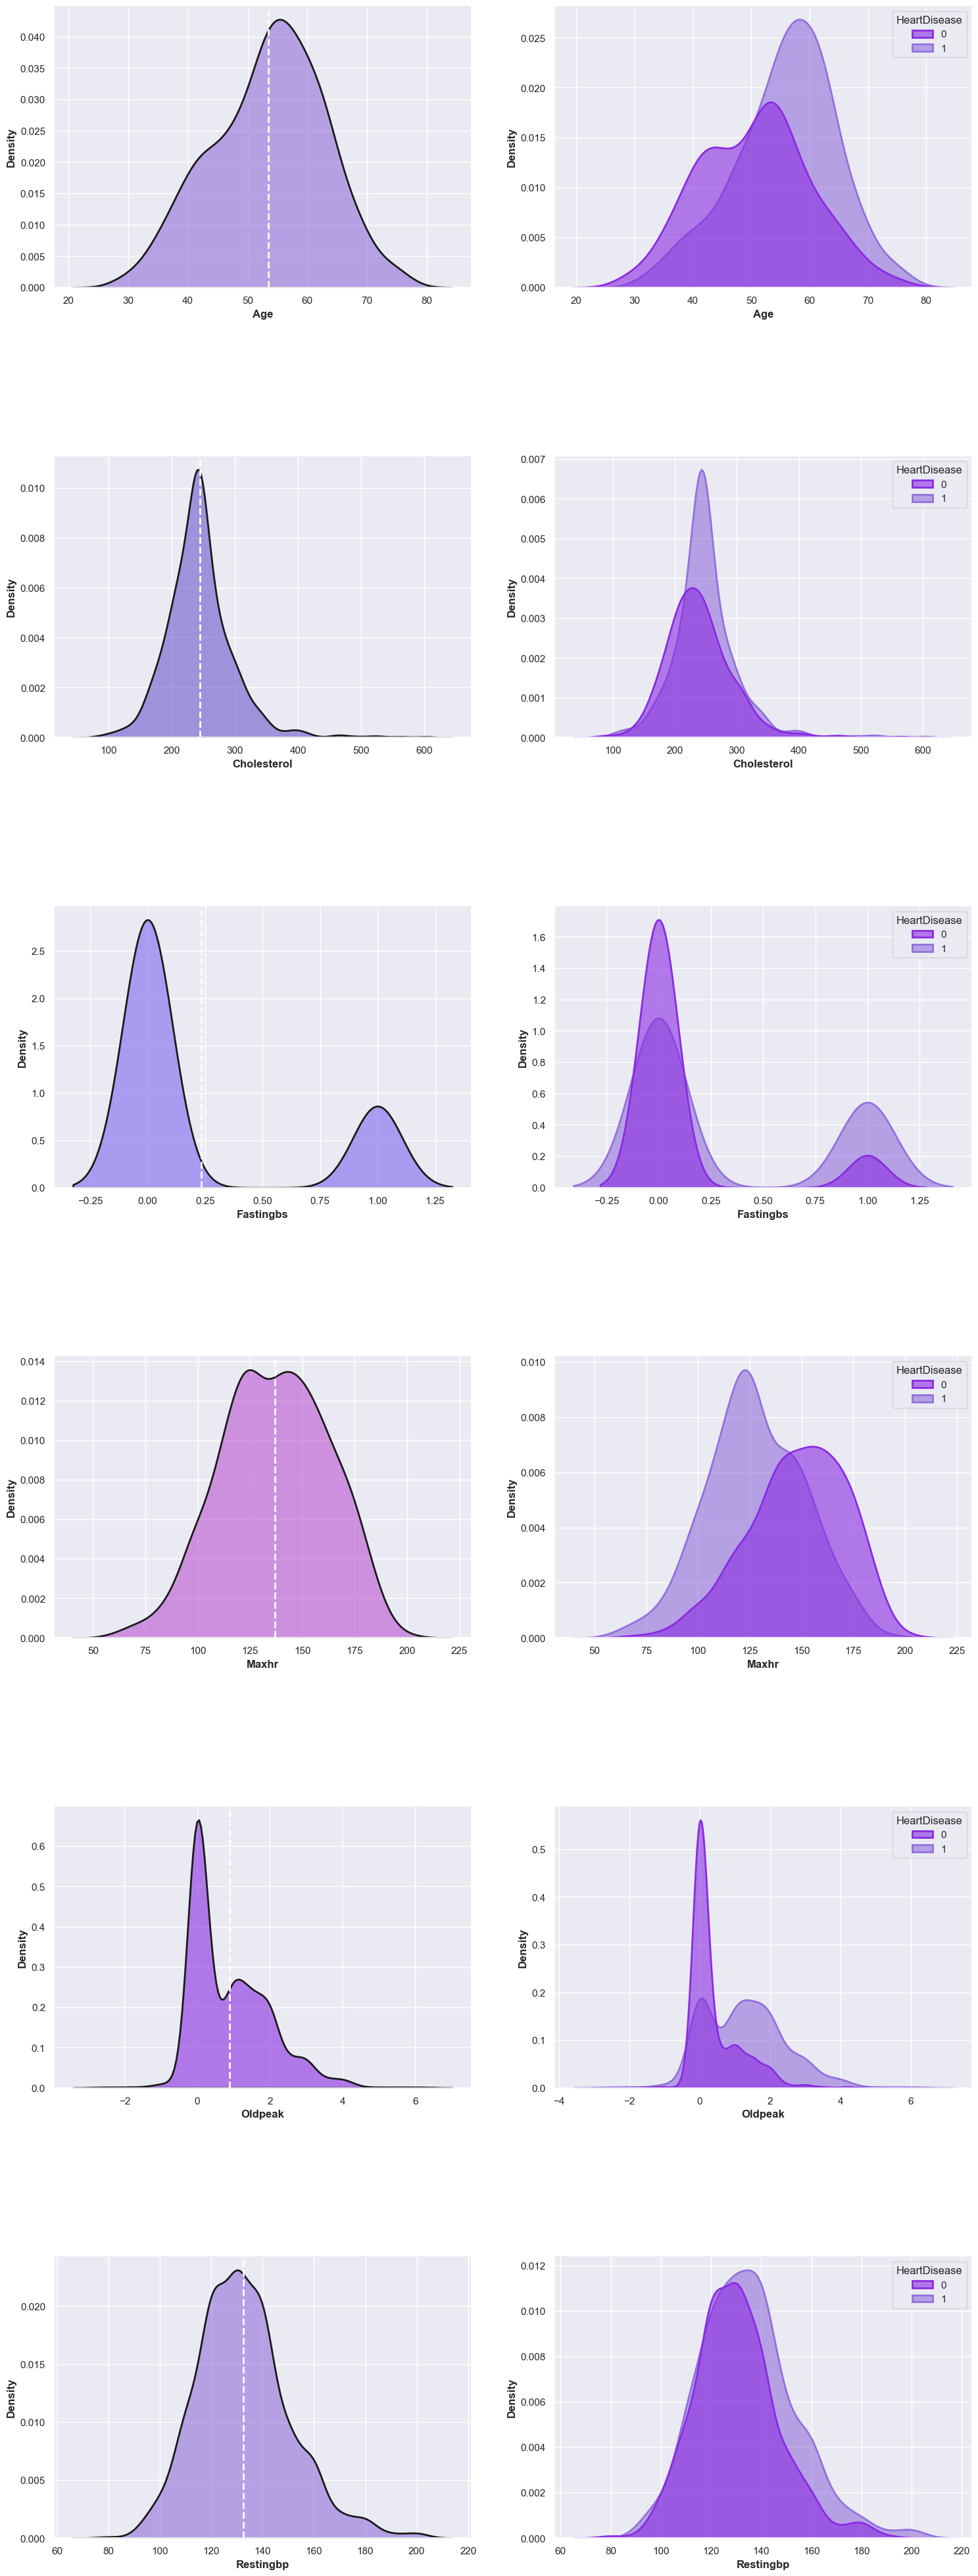

In [66]:
purple_palette = ["#8A2BE2", "#9370DB", "#6A5ACD", "#7B68EE", "#BA55D3"]

sns.set_theme(style="darkgrid")

plotIndex = 1
plt.figure(figsize=(18, 50))

for i in range(1, len(X.columns) + 1):
    column = X.columns[i - 1]

    plt.subplot(len(X.columns), 2, plotIndex)
    sns.kdeplot(
        data=X,
        x=column,
        fill=True,
        linewidth=2,
        color=purple_palette[i % len(purple_palette)],
        alpha=0.6,
        edgecolor="k",
        warn_singular=False,
    )
    plt.axvline(X[column].mean(), color="white", linestyle="--", linewidth=2)
    plt.xlabel(column.title(), fontsize=12, weight="bold")
    plt.ylabel("Density", fontsize=12, weight="bold")
    sns.despine()

    plt.subplot(len(X.columns), 2, plotIndex + 1)
    sns.kdeplot(
        data=X,
        x=column,
        fill=True,
        hue=y,
        linewidth=2,
        palette=purple_palette[: len(y.unique())],
        alpha=0.6,
        warn_singular=False,
    )
    plt.xlabel(column.title(), fontsize=12, weight="bold")
    plt.ylabel("Density", fontsize=12, weight="bold")
    sns.despine()

    plotIndex += 2

plt.subplots_adjust(hspace=0.6)
plt.savefig("image/kde_plot.png")
plt.show()

In [67]:
for column in X.columns:
    mean_value = X[column].mean()
    median_value = X[column].median()
    std_value = X[column].std()
    min_value = X[column].min()
    max_value = X[column].max()

    q25 = X[column].quantile(0.25)
    q50 = X[column].quantile(0.50)
    q75 = X[column].quantile(0.75)

    skew = X[column].skew()
    kurtosis = X[column].kurtosis()

    print(f"Statistics for '{column}':")
    print(f"  Mean: {mean_value:.2f}")
    print(f"  Median: {median_value:.2f}")
    print(f"  Std Dev: {std_value:.2f}")
    print(f"  Min: {min_value:.2f}, Max: {max_value:.2f}")
    print(
        f"  25th percentile: {q25:.2f}, 50th percentile: {q50:.2f}, 75th percentile: {q75:.2f}"
    )
    print(f"  Skew: {skew:.2f}, Kurtosis: {kurtosis:.2f}")
    print("-" * 40)

Statistics for 'Age':
  Mean: 53.51
  Median: 54.00
  Std Dev: 9.43
  Min: 28.00, Max: 77.00
  25th percentile: 47.00, 50th percentile: 54.00, 75th percentile: 60.00
  Skew: -0.20, Kurtosis: -0.39
----------------------------------------
Statistics for 'Cholesterol':
  Mean: 244.50
  Median: 241.00
  Std Dev: 53.38
  Min: 85.00, Max: 603.00
  25th percentile: 214.00, 50th percentile: 241.00, 75th percentile: 267.00
  Skew: 1.38, Kurtosis: 6.23
----------------------------------------
Statistics for 'FastingBS':
  Mean: 0.23
  Median: 0.00
  Std Dev: 0.42
  Min: 0.00, Max: 1.00
  25th percentile: 0.00, 50th percentile: 0.00, 75th percentile: 0.00
  Skew: 1.26, Kurtosis: -0.40
----------------------------------------
Statistics for 'MaxHR':
  Mean: 136.81
  Median: 138.00
  Std Dev: 25.46
  Min: 60.00, Max: 202.00
  25th percentile: 120.00, 50th percentile: 138.00, 75th percentile: 156.00
  Skew: -0.14, Kurtosis: -0.45
----------------------------------------
Statistics for 'Oldpeak':
  

In [68]:
for column in X.columns:
    group_0 = X[y == 0][column]
    group_1 = X[y == 1][column]

    mean_0 = group_0.mean()
    mean_1 = group_1.mean()

    std_0 = group_0.std()
    std_1 = group_1.std()

    median_0 = group_0.median()
    median_1 = group_1.median()

    from scipy.stats import ttest_ind

    t_stat, p_value = ttest_ind(group_0, group_1)

    print(f"Statistics for '{column}':")
    print(
        f"  Class 0: Mean = {mean_0:.2f}, Std Dev = {std_0:.2f}, Median = {median_0:.2f}"
    )
    print(
        f"  Class 1: Mean = {mean_1:.2f}, Std Dev = {std_1:.2f}, Median = {median_1:.2f}"
    )
    print(f"  T-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print(
            f"  The difference between class 0 and class 1 is statistically significant (p-value < 0.05)"
        )
    else:
        print(
            f"  No significant difference between class 0 and class 1 (p-value >= 0.05)"
        )
    print("-" * 40)

Statistics for 'Age':
  Class 0: Mean = 50.55, Std Dev = 9.44, Median = 51.00
  Class 1: Mean = 55.90, Std Dev = 8.73, Median = 57.00
  T-test: t-statistic = -8.90, p-value = 0.0000
  The difference between class 0 and class 1 is statistically significant (p-value < 0.05)
----------------------------------------
Statistics for 'Cholesterol':
  Class 0: Mean = 239.02, Std Dev = 54.05, Median = 235.00
  Class 1: Mean = 248.92, Std Dev = 52.46, Median = 243.79
  T-test: t-statistic = -2.80, p-value = 0.0051
  The difference between class 0 and class 1 is statistically significant (p-value < 0.05)
----------------------------------------
Statistics for 'FastingBS':
  Class 0: Mean = 0.11, Std Dev = 0.31, Median = 0.00
  Class 1: Mean = 0.33, Std Dev = 0.47, Median = 0.00
  T-test: t-statistic = -8.40, p-value = 0.0000
  The difference between class 0 and class 1 is statistically significant (p-value < 0.05)
----------------------------------------
Statistics for 'MaxHR':
  Class 0: Mean = 

# Feature binarization

In [69]:
scales = ["ordinal", "categorical", "binary"]
features_by_scale = {
    "ordinal": ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"],
    "categorical": ["ChestPainType", "RestingECG", "ST_Slope"],
    "binary": ["Sex", "FastingBS", "ExerciseAngina"],
}
boundaries = {
    "Age": [35, 50, 65],  # ["28-35", "36-50", "51-65", "66+"]
    "RestingBP": [
        0,
        120,
        130,
        140,
    ],  # ["Normal", "Elevated", "Hypertension Stage 1", "Hypertension Stage 2"]
    "Cholesterol": [0, 200, 240],  # ["Normal", "Borderline High", "High"]
    "MaxHR": [60, 100, 150, 200],  # ["Low", "Normal", "High"]
    "Oldpeak": [-2.6, 0, 2],  # ["Normal", "Borderline", "High"]
}


def binarize_data(input_df, features_by_scale, scales, boundaries):
    processed_df = input_df.copy()
    for scale in scales:
        for feature in features_by_scale[scale]:
            processed_df.drop(columns=feature, inplace=True)
            if scale == "ordinal":
                for boundary in boundaries[feature]:
                    processed_df[f"{feature}>={boundary}"] = (
                        input_df[feature] >= boundary
                    )
            elif scale in ["categorical", "binary"]:
                prefix = feature if scale == "binary" else ""
                prefix_separator = "_" if scale == "binary" else ""
                dummies = pd.get_dummies(
                    input_df[feature], prefix=prefix, prefix_sep=prefix_separator
                )
                processed_df = pd.concat([processed_df, dummies], axis=1)
    return processed_df


df_bin = binarize_data(df, features_by_scale, scales, boundaries)

### Dichotomic Scale

The following features are represented by two unique values, making them suitable for a dichotomous scale. This approach converts these features into binary attributes:

- `Sex`: Biological sex (`Male`, `Female`).
- `FastingBS`: Fasting blood sugar > 120 mg/dL (`Yes`, `No`).
- `ExerciseAngina`: Exercise-induced angina (`Yes`, `No`).

---

### Nominal Scale

For features with more than two unique values, a nominal scale is used to binarize each category into separate attributes:

- `ChestPainType`: Type of chest pain experienced:
  - `Typical Angina`
  - `Atypical Angina`
  - `Non-Anginal Pain`
  - `Asymptomatic`
- `RestingECG`: Resting electrocardiogram results:
  - `Normal`
  - `ST-T Wave Abnormality`
  - `Left Ventricular Hypertrophy`
- `ST_Slope`: Slope of the peak exercise ST segment:
  - `Upsloping`
  - `Flat`
  - `Downsloping`

---

### Inter-Ordinal Scale

Numeric features are divided into intervals to retain clinically relevant information while simplifying analysis. The boundaries balance clinical thresholds with logical grouping.

#### 1. **Age**

**Explanation**: Age is a critical factor affecting the risk of cardiovascular diseases. Young individuals generally have a lower risk, whereas older adults are at higher risk.

**Min/Max Values**:
- Min: 28 years
- Max: 77 years

**Proposed Categories**:
- **Young Age (18-35 years)**: At this age, the risk of cardiovascular diseases is minimal, though cases with hereditary predispositions can occur.
- **Middle Age (36-50 years)**: This age range sees the beginning of an increased risk due to lifestyle factors such as lack of physical activity, poor diet, and stress.
- **Older Age (51-65 years)**: Cardiovascular diseases related to age start becoming more prevalent in this range.
- **Elderly (66+ years)**: High risk of cardiovascular diseases, hypertension, and other age-related conditions.

**Boundaries**:
- **Young Age**: 28-35 years
- **Middle Age**: 36-50 years
- **Older Age**: 51-65 years
- **Elderly**: 66+ years

---

#### 2. **Resting Blood Pressure (RestingBP)**

**Explanation**: Blood pressure is a key indicator of cardiovascular health. High blood pressure (hypertension) is one of the leading risk factors for stroke, heart attacks, and other diseases.

**Min/Max Values**:
- Min: 80 mmHg
- Max: 200 mmHg

**Proposed Categories**:
- **Normal Blood Pressure (< 120 mmHg)**: Normal blood pressure reduces the risk of cardiovascular diseases.
- **Pre-hypertension (120-129 mmHg)**: This condition may be a precursor to hypertension and requires monitoring.
- **Hypertension Stage 1 (130-139 mmHg)**: Lifestyle modifications and possible medication are recommended.
- **Hypertension Stage 2 (≥ 140 mmHg)**: Serious risk of cardiovascular diseases, requiring ongoing treatment.

**Boundaries**:
- **Normal Blood Pressure**: < 120 mmHg
- **Pre-hypertension**: 120-129 mmHg
- **Hypertension Stage 1**: 130-139 mmHg
- **Hypertension Stage 2**: ≥ 140 mmHg

---

#### 3. **Cholesterol**

**Explanation**: Cholesterol is an important marker for assessing the risk of cardiovascular diseases. High cholesterol levels can lead to the formation of atherosclerotic plaques in arteries, increasing the risk of heart attacks and strokes.

**Min/Max Values**:
- Min: 85 mg/dL
- Max: 603 mg/dL

**Proposed Categories**:
- **Normal Cholesterol (< 200 mg/dL)**: Recommended for heart health.
- **Borderline High (200-239 mg/dL)**: The risk of heart diseases begins to increase.
- **High Cholesterol (≥ 240 mg/dL)**: The risk of cardiovascular diseases is significantly increased, and treatment to lower cholesterol levels is necessary.

**Boundaries**:
- **Normal Cholesterol**: < 200 mg/dL
- **Borderline High**: 200-239 mg/dL
- **High Cholesterol**: ≥ 240 mg/dL

---

#### 4. **Max Heart Rate (MaxHR)**

**Explanation**: MaxHR is the highest heart rate an individual can achieve during intense physical activity. It is influenced by age and physical condition. A high max HR may indicate low physical fitness or the presence of certain health conditions.

**Min/Max Values**:
- Min: 60 bpm
- Max: 202 bpm

**Proposed Categories**:
- **Low Heart Rate (< 70% of max heart rate for age)**: May indicate good physical fitness or physiological conditions.
- **Normal Heart Rate (70-85% of max heart rate for age)**: This is the normal range for most individuals during moderate activity.
- **High Heart Rate (> 85% of max heart rate for age)**: May indicate overexertion or low physical fitness.

**Boundaries**:
- **Low Heart Rate**: < 70% of max heart rate for age
- **Normal Heart Rate**: 70-85% of max heart rate for age
- **High Heart Rate**: > 85% of max heart rate for age

---

#### 5. **Oldpeak**

**Explanation**: Oldpeak is a measure used to assess ST-segment depression on an ECG. It is often used to detect heart ischemia and the heart's ability to withstand stress. Negative values suggest ischemia or stress, while positive values indicate possible recovery after stress.

**Min/Max Values**:
- Min: -2.6
- Max: 6.2

**Proposed Categories**:
- **Normal Value (0 or near 0)**: Typically indicates no issues with cardiovascular health.
- **Borderline Changes (0 to 2)**: May indicate mild deviations, requiring attention, but not necessarily indicative of disease.
- **Significant Changes (> 2)**: Significant deviations that may suggest more severe cardiovascular diseases such as heart ischemia.

**Boundaries**:
- **Normal Value**: 0 or near 0
- **Borderline Changes**: 0 to 2
- **Significant Changes**: > 2

In [70]:
scales = ["ordinal", "categorical", "binary"]
features_by_scale = {
    "ordinal": ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"],
    "categorical": ["ChestPainType", "RestingECG", "ST_Slope"],
    "binary": ["Sex", "FastingBS", "ExerciseAngina"],
}
boundaries = {
    "Age": [35, 50, 65],  # ["18-35", "36-50", "51-65", "66+"]
    "RestingBP": [
        120,
        130,
        140,
    ],  # ["Normal", "Elevated", "Hypertension Stage 1", "Hypertension Stage 2"]
    "Cholesterol": [200, 240],  # ["Normal", "Borderline High", "High"]
    "MaxHR": [100, 150, 200],  # ["Low", "Normal", "High"]
    "Oldpeak": [0, 2],  # ["Normal", "Borderline", "High"]
}


def binarize_data(input_df, features_by_scale, scales, boundaries):
    processed_df = input_df.copy()
    for scale in scales:
        for feature in features_by_scale[scale]:
            processed_df.drop(columns=feature, inplace=True)
            if scale == "ordinal":
                for boundary in boundaries[feature]:
                    processed_df[f"{feature}>={boundary}"] = (
                        input_df[feature] >= boundary
                    )
            elif scale in ["categorical", "binary"]:
                prefix = feature if scale == "binary" else ""
                prefix_separator = "_" if scale == "binary" else ""
                dummies = pd.get_dummies(
                    input_df[feature], prefix=prefix, prefix_sep=prefix_separator
                )
                processed_df = pd.concat([processed_df, dummies], axis=1)
    return processed_df


df_bin = binarize_data(df, features_by_scale, scales, boundaries)

In [71]:
columns_df = pd.DataFrame(df_bin.columns, columns=["Column Name"])
columns_df

,Column Name
0,HeartDisease
1,Age>=35
2,Age>=50
3,Age>=65
4,RestingBP>=120
5,RestingBP>=130
6,RestingBP>=140
7,Cholesterol>=200
8,Cholesterol>=240
9,MaxHR>=100


# Lazy FCA (baseline)

In [87]:
df_bin = df_bin.head(100)
df = df.head(100)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    df_bin, df.HeartDisease, test_size=0.2, stratify=df.HeartDisease, random_state=42
)

In [89]:
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train

    def classify_sample(self, sample: pd.Series) -> Any:
        # Split X_train into positive and negative classes
        X_pos = self.X_train[y_train == 1]
        X_neg = self.X_train[y_train == 0]

        positive_classifiers = 0
        negative_classifiers = 0

        # Function to check if intersection with a train sample is a positive classifier
        def is_positive_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            return ((X_pos | ~intersection) == True).all(axis=1).sum() > 1 and (
                (X_neg | ~intersection) == True
            ).all(axis=1).sum() == 0

        # Function to check if intersection is a negative classifier
        def is_negative_classifier(intersection):
            # Find samples in X_train_negative that contain the intersection
            return ((X_neg | ~intersection) == True).all(axis=1).sum() > 1 and (
                (X_pos | ~intersection) == True
            ).all(axis=1).sum() == 0

        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in X_pos.iterrows():
            intersection = sample & pos_sample
            if is_positive_classifier(intersection):
                positive_classifiers += 1

        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in X_neg.iterrows():
            intersection = sample & neg_sample
            if is_negative_classifier(intersection):
                negative_classifiers += 1

        # Determine the class based on the number of classifiers
        if positive_classifiers > negative_classifiers:
            print(
                f"sample {sample.name} is classified as 1, {positive_classifiers=}, {negative_classifiers=}"
            )
            return 1  # Predict positive

        elif negative_classifiers > positive_classifiers:
            print(
                f"sample {sample.name} is classified as 0, {positive_classifiers=}, {negative_classifiers=}"
            )
            return 0  # Predict negative

        else:
            # If equal, you can decide on a rule, like defaulting to 0 or 1, or returning 'undetermined'
            print(
                f"sample {sample.name} is classified as 1, default, {positive_classifiers=}, {negative_classifiers=}"
            )

            return 1  # or 0, depending on the choice

    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        # List to store predictions for each test sample
        return [self.classify_sample(sample) for _, sample in X_test.iterrows()]

# Lazy FCA (new implementation)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import random


class LazyClassifierFCA(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold: float = 0.5, bias: str = "positive"):
        self.X_train = None
        self.y_train = None
        self.threshold = threshold
        self.bias = bias

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        return self

    def classify_sample(self, sample: pd.Series) -> Any:
        # Split X_train into positive and negative classes
        X_pos = self.X_train[y_train == 1]
        X_neg = self.X_train[y_train == 0]

        positive_classifiers = 0
        negative_classifiers = 0

        # Function to check if intersection with a train sample is a positive classifier
        def is_positive_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            num_positive = ((X_pos | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_neg | ~intersection) == True).all(axis=1).sum()

            return (
                num_negative == 0
                and num_positive > 1
                and (num_positive / len(X_pos)) >= self.threshold
            )

        # Function to check if intersection is a negative classifier
        def is_negative_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            num_positive = ((X_pos | ~intersection) == True).all(axis=1).sum()
            num_negativ = ((X_neg | ~intersection) == True).all(axis=1).sum()

            return (
                num_negative > 1
                and num_positive == 0
                and (num_negative / len(X_neg)) >= self.threshold
            )

        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in X_pos.iterrows():
            intersection = sample & pos_sample
            if is_positive_classifier(intersection):
                positive_classifiers += 1

        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in X_neg.iterrows():
            intersection = sample & neg_sample
            if is_negative_classifier(intersection):
                negative_classifiers += 1

        # Determine the class based on the number of classifiers
        if positive_classifiers > negative_classifiers:
            print(
                f"sample {sample.name} is classified as 1, {positive_classifiers=}, {negative_classifiers=}"
            )
            return 1  # Predict positive

        elif negative_classifiers > positive_classifiers:
            print(
                f"sample {sample.name} is classified as 0, {positive_classifiers=}, {negative_classifiers=}"
            )
            return 0  # Predict negative

        else:
            if self.bias == "random":
                rand_value = random.choice([1, 0])
                print(
                    f"sample {sample.name} is classified as {rand_value}, default, {positive_classifiers=}, {negative_classifiers=}"
                )
                return random.choice([1, 0])
            elif self.bias == "positive":
                print(
                    f"sample {sample.name} is classified as 1, default, {positive_classifiers=}, {negative_classifiers=}"
                )
                return 1
            else:
                print(
                    f"sample {sample.name} is classified as 0, default, {positive_classifiers=}, {negative_classifiers=}"
                )
                return 0

    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        # List to store predictions for each test sample
        return [self.classify_sample(sample) for _, sample in X_test.iterrows()]

In [109]:
pos_X_train, neg_X_train = X_train[y_train == 1], X_train[y_train == 0]
print(f"Positive samples: {len(pos_X_train)}, Negative samples: {len(neg_X_train)}")

Positive samples: 28, Negative samples: 52


In [110]:
classifier = LazyClassifierFCA()
classifier.fit(X_train, y_train)

LazyClassifierFCA()

In [111]:
sample = X_test.iloc[1]
print(f"Sample class: {y_test.iloc[1]}\n")
classifier.classify_sample(sample)

Sample class: 1

sample 11 is classified as 1, positive_classifiers=4, negative_classifiers=0


1

In [112]:
y_pred = classifier.predict(X_test)

sample 83 is classified as 0, positive_classifiers=0, negative_classifiers=3
sample 11 is classified as 1, positive_classifiers=4, negative_classifiers=0
sample 27 is classified as 0, positive_classifiers=0, negative_classifiers=4
sample 34 is classified as 0, positive_classifiers=0, negative_classifiers=1
sample 29 is classified as 0, positive_classifiers=0, negative_classifiers=7
sample 95 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 15 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 78 is classified as 0, positive_classifiers=0, negative_classifiers=4
sample 19 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 35 is classified as 0, positive_classifiers=0, negative_classifiers=2
sample 86 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 10 is classified as 0, positive_classifiers=0, negative_classifiers=4
sample 50 is classified as 1, default, p

# Model Evaluation and Comparison

The following performance metrics were computed for the test set predictions, providing a comprehensive understanding of the model’s performance.

|||||
|----------------------------------|---------------------------------|---------------------------|----------------------------|
| True Positive (TP)               | True Negative (TN)              |  False Positive (FP)      |  False Negative (FN)       |
| True Negative Rate (Specificity) | Negative Predictive Value (NPV) |  False Positive Rate (FPR)|  False Discovery Rate (FDR)|
| Precision                        | Recall (True Positive Rate)     |  Accuracy                 |  F1 Score                  |

These metrics were computed for the test set predictions, providing a comprehensive understanding of the model’s performance.

We compared the FCA classifier against several standard classification algorithms:

|                              |                     |
|------------------------------|---------------------|
| K Nearest Neighbor (kNN)     | Logistic Regression |
| Support Vector Machine (SVM) | Decision Tree       | 
| XGBoost                      | Random Forest       |                  
| Naive bayes                  |                     |   

In [113]:
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Metrics calculations
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {
        "True Positive": tp,
        "True Negative": tn,
        "False Positive": fp,
        "False Negative": fn,
        "Specificity": specificity,
        "NPV": npv,
        "FPR": fpr,
        "FDR": fdr,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import time

In [115]:
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9]}),
    "Naive Bayes": (GaussianNB(), {}),
    "Logistic Regression": (LogisticRegression(max_iter=1000), {"C": [0.1, 1, 10]}),
    "SVM": (SVC(probability=True), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [None, 10, 20, 30]}),
    "Random Forest": (
        RandomForestClassifier(),
        {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]},
    ),
    "LazyClassifierFCA": (LazyClassifierFCA(), {}),
}

In [116]:
metrics_list = []

for model_name, (model, params) in models.items():
    print(f"Training {model_name}...")
    start_time = time.time()

    if params:
        grid = GridSearchCV(model, params, cv=3, scoring="accuracy")
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_train)

    train_time = time.time() - start_time
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    pred_time = time.time() - start_time

    metrics = calculate_metrics(y_test, y_pred)
    metrics["Training Time (s)"] = round(train_time, 4)
    metrics["Prediction Time (s)"] = round(pred_time, 4)
    metrics["Total Runtime (s)"] = round(train_time + pred_time, 4)

    metrics["Model"] = model_name
    metrics_list.append(metrics)

    print(f"Training time: {train_time:.2f}s, Prediction time: {pred_time:.2f}s")

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df[
    ["Model"] + [col for col in metrics_df.columns if col != "Model"]
]

Training KNN...
Training time: 0.10s, Prediction time: 0.00s
Training Naive Bayes...
Training time: 0.00s, Prediction time: 0.00s
Training Logistic Regression...
Training time: 0.06s, Prediction time: 0.00s
Training SVM...
Training time: 0.10s, Prediction time: 0.00s
Training Decision Tree...
Training time: 0.05s, Prediction time: 0.00s
Training Random Forest...
Training time: 3.05s, Prediction time: 0.00s
Training XGBoost...
Training time: 1.20s, Prediction time: 0.01s
Training LazyClassifierFCA...
sample 83 is classified as 0, positive_classifiers=0, negative_classifiers=3
sample 11 is classified as 1, positive_classifiers=4, negative_classifiers=0
sample 27 is classified as 0, positive_classifiers=0, negative_classifiers=4
sample 34 is classified as 0, positive_classifiers=0, negative_classifiers=1
sample 29 is classified as 0, positive_classifiers=0, negative_classifiers=7
sample 95 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 15 is classified 

In [117]:
metrics_df

,Model,True Positive,True Negative,False Positive,False Negative,Specificity,NPV,FPR,FDR,Accuracy,Precision,Recall,F1 Score,Training Time (s),Prediction Time (s),Total Runtime (s)
0,KNN,7,13,0,0,1.000000,1.0,0.000000,0.000,1.00,1.000,1.0,1.000000,0.1037,0.0030,0.1067
1,Naive Bayes,7,13,0,0,1.000000,1.0,0.000000,0.000,1.00,1.000,1.0,1.000000,0.0019,0.0010,0.0029
2,Logistic Regression,7,13,0,0,1.000000,1.0,0.000000,0.000,1.00,1.000,1.0,1.000000,0.0618,0.0010,0.0628
3,SVM,7,13,0,0,1.000000,1.0,0.000000,0.000,1.00,1.000,1.0,1.000000,0.1011,0.0010,0.1021
4,Decision Tree,7,13,0,0,1.000000,1.0,0.000000,0.000,1.00,1.000,1.0,1.000000,0.0508,0.0010,0.0518
5,Random Forest,7,13,0,0,1.000000,1.0,0.000000,0.000,1.00,1.000,1.0,1.000000,3.0501,0.0020,3.0522
6,XGBoost,7,13,0,0,1.000000,1.0,0.000000,0.000,1.00,1.000,1.0,1.000000,1.1958,0.0081,1.2039
7,LazyClassifierFCA,7,12,1,0,0.923077,1.0,0.076923,0.125,0.95,0.875,1.0,0.933333,0.0000,1.2188,1.2188


In [ ]:
metrics_df_copy = metrics_df.copy()
new_columns = metrics_df_copy["Model"].values
metrics_df_copy = metrics_df_copy.drop(columns=["Model"])
transposed_df = metrics_df_copy.T
transposed_df.columns = new_columns

transposed_df

,KNN,Naive Bayes,Logistic Regression,SVM,Decision Tree,Random Forest,XGBoost,LazyClassifierFCA
True Positive,97.000000,102.0,102.0000,102.0000,102.0000,102.0000,102.0000,102.000000
True Negative,74.000000,82.0,82.0000,82.0000,82.0000,82.0000,82.0000,50.000000
False Positive,8.000000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,32.000000
False Negative,5.000000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000
Specificity,0.902439,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,0.609756
NPV,0.936709,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,1.000000
FPR,0.097561,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.390244
FDR,0.076190,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.238806
Accuracy,0.929348,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,0.826087
Precision,0.923810,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,0.761194


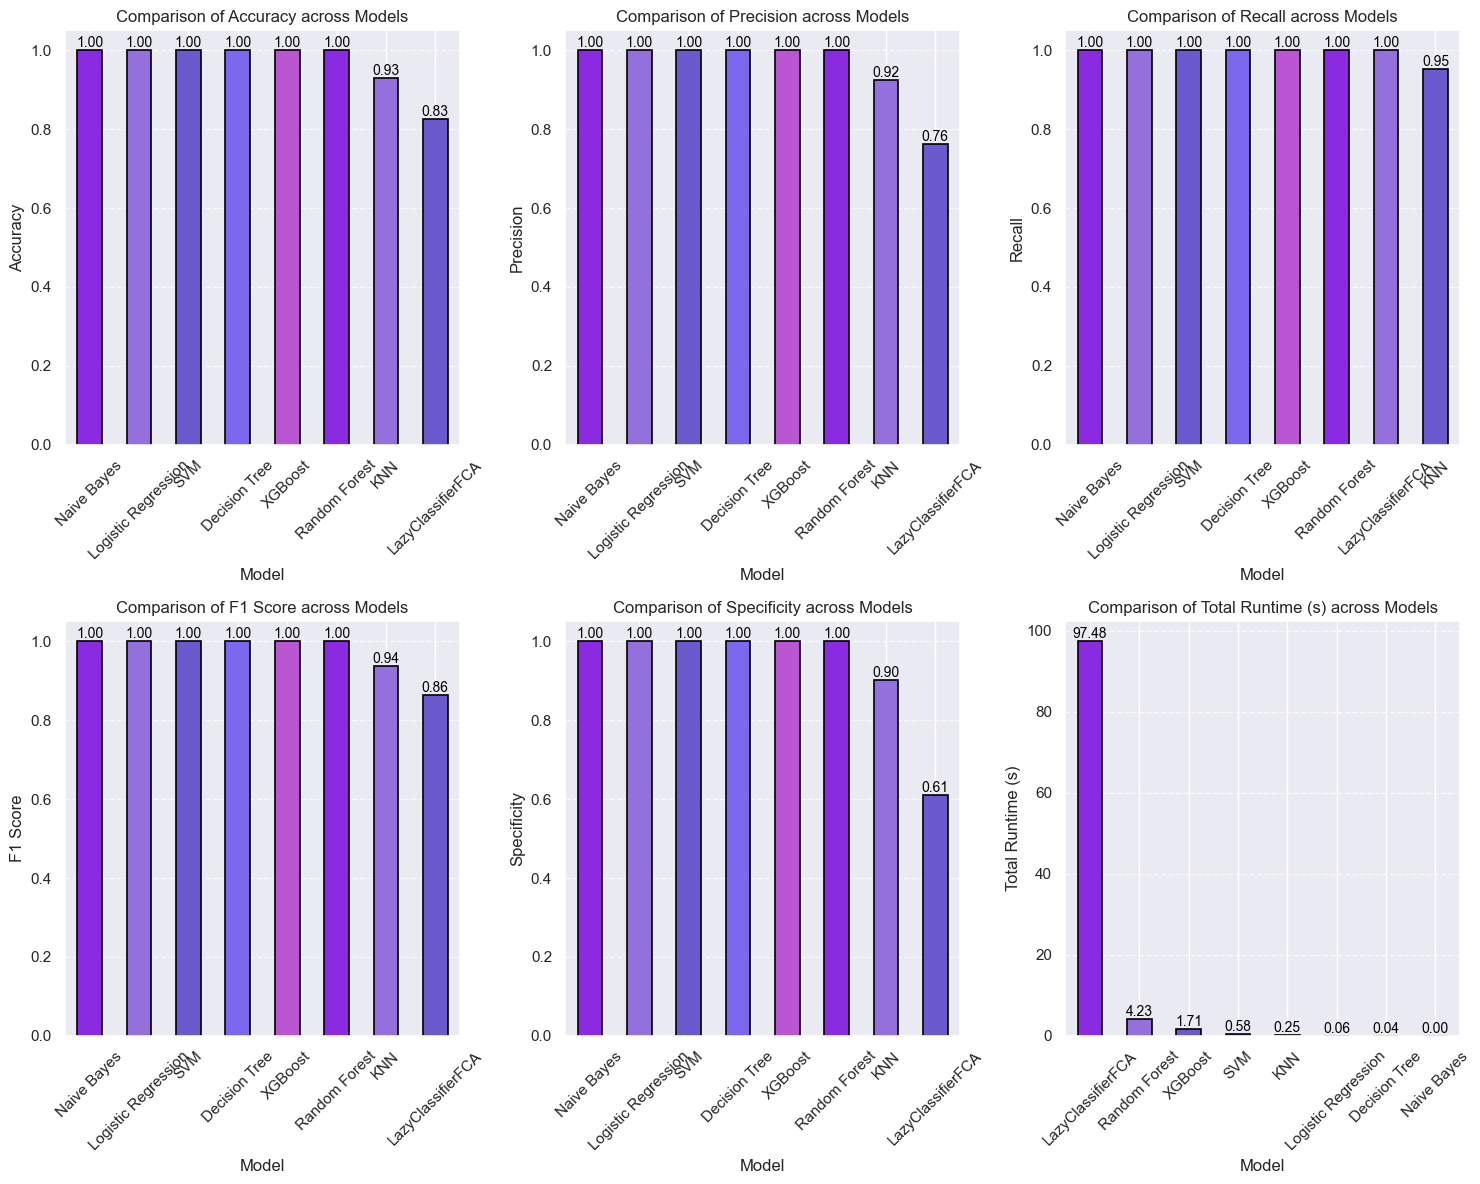

In [85]:
metrics_to_plot = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Specificity",
    "Total Runtime (s)",
]

n_columns = 3
n_rows = (len(metrics_to_plot) + n_columns - 1) // n_columns

fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 6 * n_rows))

axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sorted_metrics = metrics_df[metric].sort_values(ascending=False)

    sorted_metrics.plot(
        kind="bar",
        color=purple_palette[: len(sorted_metrics)],
        edgecolor="black",
        linewidth=1.2,
        ax=ax,
    )

    for idx, value in enumerate(sorted_metrics):
        ax.text(
            idx,
            value,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )

    ax.set_title(f"Comparison of {metric} across Models")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.set_xticklabels(metrics_df.loc[sorted_metrics.index, "Model"], rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("image/model_comparison.png")
plt.show()